# Monte Carlo simulation

Please cite: V. C. Chmielewski and E. C. Bruning (2016), Lightning Mapping Array flash detection performance with variable receiver thresholds, J. Geophys. Res. Atmos., 121, 8600-8614, doi:10.1002/2016JD025159

If any results from this model are presented.

Contact:
vanna.chmielewski@ttu.edu

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pyproj as proj4
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

# import read_logs
from mpl_toolkits.basemap import Basemap
from coordinateSystems import TangentPlaneCartesianSystem, GeographicSystem, MapProjection
import scipy.stats as st

In [3]:
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Ellipse

In [4]:
import parsed_functions as pf
import simulation_ellipse as se

sq = np.load('source_quantiles',fix_imports='True', encoding='latin1') # in Watts 
fde = 100-np.load('fde.csv',fix_imports='True', encoding='latin1') # Corresponding flash DE

In [5]:
c0 = 3.0e8 # m/s
dt_rms = 23.e-9 # seconds
lma_digitizer_window = 40.0e-9 # seconds per sample

### Station coordinates and thresholds from a set of log files 
#### Specify: 
* start time 
* end time 
* the directory holding the log files 
* any stations you wish to exclude from the analysis

In [6]:
# import os

# # start_time = datetime.datetime(2014,5,26,2) #25 set
# # end_time   = datetime.datetime(2014,5,26,3,50)
# useddir = '/Users/Vanna/Documents/logs/'
# exclude = np.array(['W','A',])

# days = np.array([start_time+datetime.timedelta(days=i) for i in range((end_time-start_time).days+1)])
# days_string = np.array([i.strftime("%y%m%d") for i in days])

# logs = pd.DataFrame()
# dir = os.listdir(useddir)
# for file in dir:
#     if np.any(file[2:] == days_string) & np.all(exclude!=file[1]): 
#         print file
#         logs = logs.combine_first(read_logs.parsing(useddir+file,T_set='True'))

# aves = logs[start_time:end_time].mean()
# aves = np.array(aves).reshape(4,len(aves)/4).T

### Station coordinates from csv file

Input network title and csv file here

In [7]:
Network = 'grid_LMA' # name of network in the csv file

stations = pd.read_csv('network.csv') # network csv file with one or multiple networks
stations.set_index('network').loc[Network]
aves = np.array(stations.set_index('network').loc[Network])[:,:-1].astype('float')

### Setting up and checking station locations

In [8]:
center = (np.mean(aves[:,1]), np.mean(aves[:,2]), np.mean(aves[:,0]))
geo  = GeographicSystem()
tanp = TangentPlaneCartesianSystem(center[0], center[1], center[2])
mapp = MapProjection
projl = MapProjection(projection='laea', lat_0=center[0], lon_0=center[1])

alt, lat, lon  = aves[:,:3].T
stations_ecef  = np.array(geo.toECEF(lon, lat, alt)).T
stations_local = tanp.toLocal(stations_ecef.T).T

center_ecef = np.array(geo.toECEF(center[1],center[0],center[2]))
ordered_threshs = aves[:,-1]

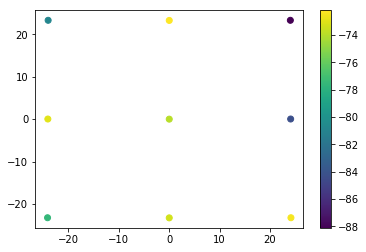

In [9]:
plt.scatter(stations_local[:,0]/1000., stations_local[:,1]/1000., c=aves[:,3])
plt.colorbar()

circle=plt.Circle((0,0),30,color='k',fill=False)
# plt.xlim(-80,80)
# plt.ylim(-80,80)
# fig = plt.gcf()
# fig.gca().add_artist(circle)
plt.show()

### Setting up grid

Input desired grid boundaries and interval here in meters from the center of the network (no point located over the center!)

In [10]:
xmin, xmax, xint = -300001, 299999, 20000
ymin, ymax, yint = -300001, 299999, 20000
# alts = np.arange(500,20500,500.)
alts = np.array([7000])

initial_points = np.array(np.meshgrid(np.arange(xmin,xmax+xint,xint),
                                      np.arange(ymin,ymax+yint,yint), alts))

x,y,z=initial_points.reshape((3,int(np.size(initial_points)/3)))
points2 = tanp.toLocal(np.array(projl.toECEF(x,y,z))).T

tanp_all = []
for i in range(len(aves[:,0])): 
    tanp_all = tanp_all + [TangentPlaneCartesianSystem(aves[i,1],aves[i,2],aves[i,0])]

### General calculations at grid points
Set number of iterations and solution requirements here (minimum number of contributing stations, maximum reduced chi squared value)

This fuction will return the dimensions of the covariance ellipses for solutions at each point at 'ntsd' standard deviations in the 'evalues' array (width (m), height (m), angle) and the standard deviation of altitude solution in the 'svalues' array (m)

If a source is not sampled by enough stations for a solution a RuntimeWarning will be generated, but this will not negatively impact the following calculations

In [11]:
iterations=500

evalues = np.zeros((np.shape(points2)[0],3))
svalues = np.zeros((np.shape(points2)[0],1))

# # for r,theta,z errors and standard deviations and overall detection efficiency
for i in range(len(x)):
    evalues[i],svalues[i]= se.black_boxtesting(points2[i,0], points2[i,1], points2[i,2], iterations,
             stations_local,ordered_threshs,stations_ecef,center_ecef,
             tanp_all,
             c0,dt_rms,tanp,projl,
             chi2_filter=5.,min_stations=6,ntsd=3
             )

/localdata/LMAsimulation/simulation_ellipse.py:271: RuntimeWarning: invalid value encountered in greater
  good = proj_soluts[2] > 0
/localdata/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/localdata/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/localdata/LMAsimulation/simulation_ellipse.py:275: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(proj_soluts[0][chi2[good]<chi2_filter], proj_soluts[1][chi2[good]<chi2_filter])
/localdata/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3093: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/localdata/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3093: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


### Detection efficiency

In [12]:
# Currently hard-coded to calculate over a 300 x 300 km grid around the network
latp, lonp, sde, fde_a, minp = pf.quick_method(
                 # input array must be in N x (lat, lon, alt, threshold) 
                 np.array([aves[:,1],aves[:,2],aves[:,0],aves[:,3]]).transpose(), 
                 sq, fde, 
                 xint=5000, # Grid spacing
                 altitude=7000, # Altitude of grid MSL
                 station_requirement=6, # Minimum number of stations required to trigger
                 mindist = 300000 # Grid ends 300 km from the most distant station in each direction
                )

#### Plotting horizontal errors by ellipse over detection efficiency

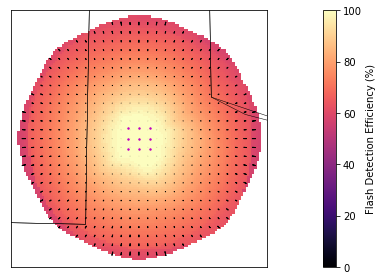

In [13]:
domain = (xmax-xint/2.)
maps = Basemap(projection='laea',lat_0=center[0],lon_0=center[1],width=domain*2,height=domain*2)
ax = plt.subplot(111)
x, y = maps(lonp, latp)

# s = plt.pcolormesh(x,y,np.ma.masked_where(sde==0,sde),cmap = 'magma') # Source detection efficiency
s = plt.pcolormesh(x,y,np.ma.masked_where(fde_a==0,fde_a),cmap = 'magma') # Flash detection efficiency
plt.colorbar(label='Flash Detection Efficiency (%)')
s.set_clim(vmin=0,vmax=100)

for i in range(len(evalues[:,0])):
    ell = Ellipse(xy=(points2[i,0]+domain, points2[i,1]+domain),
              width=evalues[i,0], height=evalues[i,1],
              angle=evalues[i,2], color='black')
    ell.set_facecolor('none')
    ax.add_artist(ell)

plt.scatter(stations_local[:,0]+domain, stations_local[:,1]+domain, color='m', s=2)
maps.drawstates()
plt.tight_layout()
plt.show()

#### Plotting horizontal errors by ellipse over standard deviation of altitude solutions

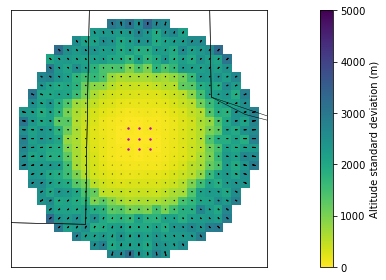

In [14]:
domain = (xmax-xint/2.)
maps = Basemap(projection='laea',lat_0=center[0],lon_0=center[1],width=domain*2,height=domain*2)
ax = plt.subplot(111)

s = plt.pcolormesh(np.arange(-xmax-xint/2.,xmax+3*xint/2.,xint)+domain,
                   np.arange(-xmax-xint/2.,xmax+3*xint/2.,xint)+domain,
                   np.ma.masked_where(svalues==0,svalues).reshape((31,31)),
                  cmap = 'viridis_r')
s.set_clim(vmin=0,vmax=5000)
plt.colorbar(label = 'Altitude standard deviation (m)')

for i in range(len(evalues[:,0])):
    ell = Ellipse(xy=(points2[i,0]+domain, points2[i,1]+domain),
              width=evalues[i,0], height=evalues[i,1],
              angle=evalues[i,2], color='black')
    ell.set_facecolor('none')
    ax.add_artist(ell)

plt.scatter(stations_local[:,0]+domain, stations_local[:,1]+domain, color='m', s=2)
maps.drawstates()
plt.tight_layout()
plt.show()